# Descriptive Analysis of eRisk Depression Dataset

This notebook performs comprehensive descriptive analysis of the raw dataset **before embeddings/retrieval**.

**Data Sources Analyzed:**
1. **Training Data** (eRisk 2017): 486 subjects with BDI-II concept labels
2. **Test Data** (eRisk 2018): 401 subjects (no concept labels)

**Analysis Scope:**
- User-level statistics (counts, prevalence, class imbalance)
- Post-level statistics (posts per user, text length distributions)
- Concept prevalence and co-occurrence (Training data only)
- Cross-dataset comparison

## Section 0: Setup & Configuration

In [1]:
# Imports
import os
import glob
import re
import zipfile
import tempfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from collections import Counter
from scipy.stats import pearsonr

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Path configuration
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_RAW = os.path.join(PROJECT_ROOT, "data/raw")
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data/processed")

# Data source paths
TRAIN_POS_DIR = os.path.join(DATA_RAW, "train/positive_examples_anonymous_chunks")
TRAIN_NEG_DIR = os.path.join(DATA_RAW, "train/negative_examples_anonymous_chunks")
TEST_DIR = os.path.join(DATA_RAW, "test")
TEST_LABELS = os.path.join(TEST_DIR, "test_golden_truth.txt")

# Concept labels
TRAIN_CONCEPTS = os.path.join(DATA_PROCESSED, "merged_questionnaires.csv")

# Output directory
OUTPUT_DIR = os.path.join(DATA_PROCESSED, "descriptive_analysis")
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

Project root: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study
Output directory: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis


In [3]:
# BDI-II Concepts (21 depression symptoms)
CONCEPT_NAMES = [
    "Sadness", "Pessimism", "Past failure", "Loss of pleasure",
    "Guilty feelings", "Punishment feelings", "Self-dislike",
    "Self-criticalness", "Suicidal thoughts or wishes", "Crying",
    "Agitation", "Loss of interest", "Indecisiveness", "Worthlessness",
    "Loss of energy", "Changes in sleeping pattern", "Irritability",
    "Changes in appetite", "Concentration difficulty",
    "Tiredness or fatigue", "Loss of interest in sex"
]

print(f"Number of BDI-II concepts: {len(CONCEPT_NAMES)}")

Number of BDI-II concepts: 21


In [4]:
# Helper functions for XML parsing (adapted from 0c notebook)

WHITESPACE_RE = re.compile(r"\s+")

def normalize_text(text):
    """Normalize text by removing null characters and extra whitespace."""
    if not text:
        return ""
    text = text.replace("\u0000", "")
    text = WHITESPACE_RE.sub(" ", text).strip()
    return text

def extract_posts_from_xml(xml_path, min_chars=10):
    """Extract posts from XML file."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        posts = []
        
        for writing in root.findall("WRITING"):
            title = writing.findtext("TITLE") or ""
            text = writing.findtext("TEXT") or ""
            combined = normalize_text(f"{title} {text}".strip())
            
            if len(combined) >= min_chars:
                posts.append(combined)
        
        return posts
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return []

print("Helper functions defined")

Helper functions defined


## Section 1: Load Training Data (eRisk 2017)

In [5]:
# Load training data XML files
print("Loading training data...")

train_data = []

# Load positive examples
pos_files = glob.glob(os.path.join(TRAIN_POS_DIR, "**", "*.xml"), recursive=True)
print(f"Found {len(pos_files)} positive training files")

for xml_file in pos_files:
    filename = os.path.basename(xml_file)
    # Match pattern: train_subject1234_1.xml
    match = re.match(r"train_(subject\d+)_\d+\.xml", filename)
    if match:
        subject_id = match.group(1)
        posts = extract_posts_from_xml(xml_file)

        for post_text in posts:
            train_data.append({
                'subject_id': subject_id,
                'label': 1,
                'text': post_text
            })

# Load negative examples
neg_files = glob.glob(os.path.join(TRAIN_NEG_DIR, "**", "*.xml"), recursive=True)
print(f"Found {len(neg_files)} negative training files")

for xml_file in neg_files:
    filename = os.path.basename(xml_file)
    # Match pattern: train_subject1234_1.xml
    match = re.match(r"train_(subject\d+)_\d+\.xml", filename)
    if match:
        subject_id = match.group(1)
        posts = extract_posts_from_xml(xml_file)

        for post_text in posts:
            train_data.append({
                'subject_id': subject_id,
                'label': 0,
                'text': post_text
            })

# Create DataFrame
train_posts_df = pd.DataFrame(train_data)

print(f"\nTraining data loaded:")
print(f"  Total posts: {len(train_posts_df):,}")
print(f"  Unique subjects: {train_posts_df['subject_id'].nunique()}")
print(f"  Positive subjects: {train_posts_df[train_posts_df['label']==1]['subject_id'].nunique()}")
print(f"  Negative subjects: {train_posts_df[train_posts_df['label']==0]['subject_id'].nunique()}")

train_posts_df.head()

Loading training data...
Found 830 positive training files
Found 4031 negative training files

Training data loaded:
  Total posts: 286,740
  Unique subjects: 486
  Positive subjects: 83
  Negative subjects: 403


,subject_id,label,text
0,subject6760,1,Swim. Dance.
1,subject6760,1,At a dinner party at house overlooking the bay...
2,subject6760,1,The 12 Worst Habits for Your Mental Health
3,subject6760,1,"Yeah, that's true. But it didn't look like a p..."
4,subject6760,1,"Unlikely. The rate of ""ascension"" was similar ..."


In [6]:
# Load training concept labels
print("Loading training concept labels...")

concepts_df = pd.read_csv(TRAIN_CONCEPTS)
print(f"Loaded concept labels: {concepts_df.shape}")

# Extract subject IDs (remove 'train_' prefix if present)
# Handle both 'Subject' and 'subject' column names
if 'Subject' in concepts_df.columns:
    concepts_df['subject_id'] = concepts_df['Subject'].str.replace('train_', '', regex=True)
elif 'subject' in concepts_df.columns:
    concepts_df['subject_id'] = concepts_df['subject'].str.replace('train_', '', regex=False)
else:
    raise ValueError("Could not find 'Subject' or 'subject' column in concepts file")

# Select concept columns (21 BDI-II symptoms) - match by concept names
concept_cols = [col for col in concepts_df.columns if col in CONCEPT_NAMES]
print(f"Concept columns found: {len(concept_cols)}")

# If no direct match, try BDI-II_ pattern
if len(concept_cols) == 0:
    concept_cols = [col for col in concepts_df.columns if col.startswith('BDI-II_')]
    print(f"Using BDI-II_ pattern, found: {len(concept_cols)} columns")

# Binarize concept values (>0 → 1)
for col in concept_cols:
    concepts_df[col] = (concepts_df[col] > 0).astype(int)

train_concepts_df = concepts_df[['subject_id'] + concept_cols].copy()

print(f"\nConcept labels processed:")
print(f"  Subjects with concept labels: {len(train_concepts_df)}")
print(f"  Concepts per subject (mean): {train_concepts_df[concept_cols].sum(axis=1).mean():.2f}")

train_concepts_df.head()

Loading training concept labels...
Loaded concept labels: (486, 23)
Concept columns found: 21

Concept labels processed:
  Subjects with concept labels: 486
  Concepts per subject (mean): 1.33


,subject_id,Sadness,Pessimism,Past failure,Loss of pleasure,Guilty feelings,Punishment feelings,Self-dislike,Self-criticalness,Suicidal thoughts or wishes,...,Loss of interest,Indecisiveness,Worthlessness,Loss of energy,Changes in sleeping pattern,Irritability,Changes in appetite,Concentration difficulty,Tiredness or fatigue,Loss of interest in sex
0,subject4550,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,subject4181,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,subject8202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,subject6783,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,subject1642,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Section 2: Load Test Data (eRisk 2018)

In [7]:
# Load test labels
print("Loading test labels...")

test_labels_dict = {}
with open(TEST_LABELS, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            subject_id, label = parts
            test_labels_dict[subject_id] = int(label)

print(f"Loaded {len(test_labels_dict)} test subject labels")
print(f"  Positive: {sum(1 for v in test_labels_dict.values() if v == 1)}")
print(f"  Negative: {sum(1 for v in test_labels_dict.values() if v == 0)}")

Loading test labels...
Loaded 401 test subject labels
  Positive: 52
  Negative: 349


In [8]:
# Extract test data from ZIP files
print("Extracting test data from ZIP files...")

# Create temporary directory
temp_dir = tempfile.mkdtemp()
print(f"Temporary directory: {temp_dir}")

# Extract all ZIP chunks
zip_files = sorted(glob.glob(os.path.join(TEST_DIR, "chunk*.zip")))
print(f"Found {len(zip_files)} ZIP files")

for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

print("Extraction complete")

Extracting test data from ZIP files...
Temporary directory: /var/folders/gb/m6c_r5xx6_14p7mlfjwk29900000gn/T/tmph69rgwfc
Found 10 ZIP files
Extraction complete


In [9]:
# Load test posts
print("Loading test posts...")

test_data = []
xml_files = glob.glob(os.path.join(temp_dir, "**", "*.xml"), recursive=True)
print(f"Found {len(xml_files)} XML files in test data")

for xml_file in xml_files:
    filename = os.path.basename(xml_file)
    # Match pattern: test_subject1234_1.xml
    match = re.match(r"(test_subject\d+)_\d+\.xml", filename)
    if match:
        subject_id = match.group(1)
        
        if subject_id in test_labels_dict:
            posts = extract_posts_from_xml(xml_file)
            label = test_labels_dict[subject_id]
            
            for post_text in posts:
                test_data.append({
                    'subject_id': subject_id,
                    'label': label,
                    'text': post_text
                })

# Create DataFrame
test_posts_df = pd.DataFrame(test_data)

print(f"\nTest data loaded:")
print(f"  Total posts: {len(test_posts_df):,}")
print(f"  Unique subjects: {test_posts_df['subject_id'].nunique()}")
print(f"  Positive subjects: {test_posts_df[test_posts_df['label']==1]['subject_id'].nunique()}")
print(f"  Negative subjects: {test_posts_df[test_posts_df['label']==0]['subject_id'].nunique()}")
print(f"\nNote: Test data has NO concept labels available")

test_posts_df.head()

Loading test posts...
Found 4010 XML files in test data

Test data loaded:
  Total posts: 229,746
  Unique subjects: 401
  Positive subjects: 52
  Negative subjects: 349

Note: Test data has NO concept labels available


,subject_id,label,text
0,test_subject3120,0,"So you're in agreement with Obama, then?"
1,test_subject3120,0,Something's off about them. I guess since they...
2,test_subject3120,0,Illuminati Ritual at Ground Zero 911 - YouTube
3,test_subject3120,0,Robert Steele is one of the originators of thi...
4,test_subject3120,0,"If you're on social security, you're a veteran..."


## Section 3: User-Level Statistics

In [10]:
# Compute user-level statistics
print("Computing user-level statistics...\n")

datasets = {
    'Train': train_posts_df,
    'Test': test_posts_df
}

user_stats = []

for dataset_name, df in datasets.items():
    total = df['subject_id'].nunique()
    positive = df[df['label']==1]['subject_id'].nunique()
    negative = df[df['label']==0]['subject_id'].nunique()
    prevalence = (positive / total) * 100 if total > 0 else 0
    imbalance = negative / positive if positive > 0 else 0
    
    user_stats.append({
        'Dataset': dataset_name,
        'Total': total,
        'Positive': positive,
        'Negative': negative,
        'Prevalence (%)': prevalence,
        'Imbalance Ratio': imbalance
    })
    
    print(f"{dataset_name} Dataset:")
    print(f"  Total subjects: {total}")
    print(f"  Positive (depressed): {positive}")
    print(f"  Negative (control): {negative}")
    print(f"  Prevalence: {prevalence:.1f}%")
    print(f"  Imbalance ratio: {imbalance:.1f}:1\n")

user_level_stats_df = pd.DataFrame(user_stats)
user_level_stats_df

Computing user-level statistics...

Train Dataset:
  Total subjects: 486
  Positive (depressed): 83
  Negative (control): 403
  Prevalence: 17.1%
  Imbalance ratio: 4.9:1

Test Dataset:
  Total subjects: 401
  Positive (depressed): 52
  Negative (control): 349
  Prevalence: 13.0%
  Imbalance ratio: 6.7:1



,Dataset,Total,Positive,Negative,Prevalence (%),Imbalance Ratio
0,Train,486,83,403,17.078189,4.855422
1,Test,401,52,349,12.967581,6.711538


In [11]:
# Save user-level statistics
output_path = os.path.join(OUTPUT_DIR, "user_level_stats.csv")
user_level_stats_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/user_level_stats.csv


Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/plots/user_counts_barplot.png


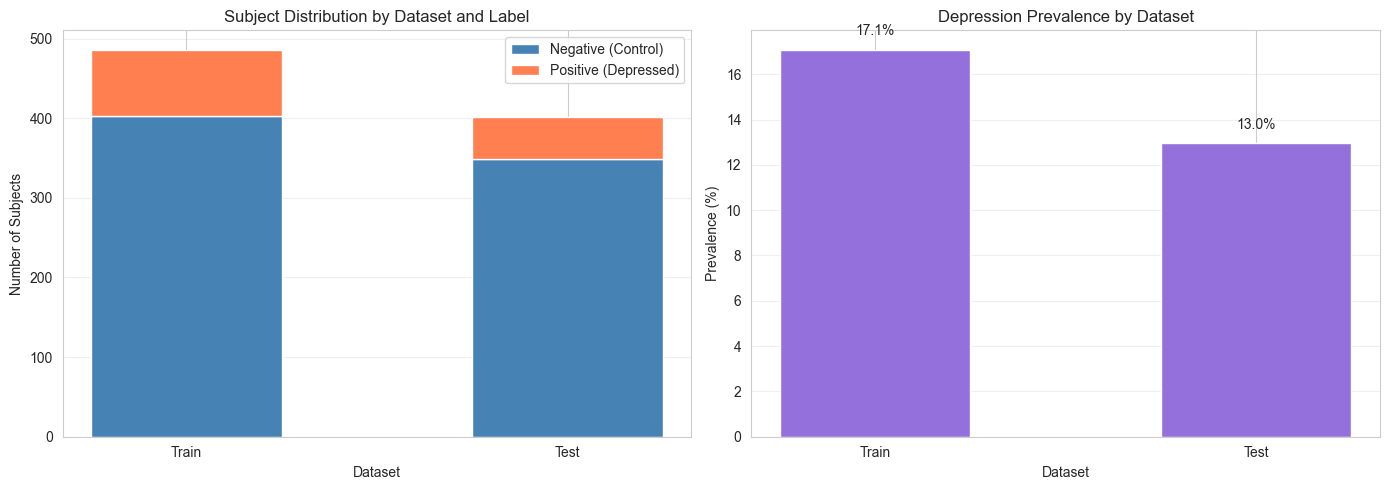

In [12]:
# Visualize user counts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
ax1 = axes[0]
datasets_list = user_level_stats_df['Dataset'].values
positive_counts = user_level_stats_df['Positive'].values
negative_counts = user_level_stats_df['Negative'].values

x = np.arange(len(datasets_list))
width = 0.5

ax1.bar(x, negative_counts, width, label='Negative (Control)', color='steelblue')
ax1.bar(x, positive_counts, width, bottom=negative_counts, label='Positive (Depressed)', color='coral')

ax1.set_xlabel('Dataset')
ax1.set_ylabel('Number of Subjects')
ax1.set_title('Subject Distribution by Dataset and Label')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets_list)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Grouped bar chart for prevalence
ax2 = axes[1]
prevalence = user_level_stats_df['Prevalence (%)'].values

ax2.bar(x, prevalence, width, color='mediumpurple')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Prevalence (%)')
ax2.set_title('Depression Prevalence by Dataset')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets_list)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(prevalence):
    ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "user_counts_barplot.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

## Section 4: Post-Level Statistics

In [13]:
# Compute posts per user statistics
print("Computing post-level statistics...\n")

posts_per_user_stats = []

for dataset_name, df in datasets.items():
    # Overall statistics
    posts_per_user = df.groupby('subject_id').size()
    
    overall_stats = {
        'Dataset': dataset_name,
        'Label': 'All',
        'Total Posts': len(df),
        'Mean': posts_per_user.mean(),
        'Median': posts_per_user.median(),
        'Std': posts_per_user.std(),
        'Min': posts_per_user.min(),
        'Max': posts_per_user.max(),
        'Q25': posts_per_user.quantile(0.25),
        'Q75': posts_per_user.quantile(0.75)
    }
    posts_per_user_stats.append(overall_stats)
    
    # By label
    for label in [0, 1]:
        label_df = df[df['label'] == label]
        posts_per_user_label = label_df.groupby('subject_id').size()
        
        label_name = 'Positive' if label == 1 else 'Negative'
        label_stats = {
            'Dataset': dataset_name,
            'Label': label_name,
            'Total Posts': len(label_df),
            'Mean': posts_per_user_label.mean(),
            'Median': posts_per_user_label.median(),
            'Std': posts_per_user_label.std(),
            'Min': posts_per_user_label.min(),
            'Max': posts_per_user_label.max(),
            'Q25': posts_per_user_label.quantile(0.25),
            'Q75': posts_per_user_label.quantile(0.75)
        }
        posts_per_user_stats.append(label_stats)

posts_per_user_df = pd.DataFrame(posts_per_user_stats)
posts_per_user_df

Computing post-level statistics...



,Dataset,Label,Total Posts,Mean,Median,Std,Min,Max,Q25,Q75
0,Train,All,286740,590.000000,302.0,612.746829,8,1995,65.75,1053.75
1,Train,Negative,256872,637.399504,336.0,633.967089,8,1995,76.50,1112.00
2,Train,Positive,29868,359.855422,132.0,430.913299,10,1774,41.50,565.00
3,Test,All,229746,572.932668,327.0,576.725886,10,1996,81.00,1043.00
4,Test,Negative,211694,606.573066,373.0,594.198706,10,1996,85.00,1068.00
5,Test,Positive,18052,347.153846,194.0,373.911407,12,1356,62.75,596.00


In [14]:
# Save posts per user statistics
output_path = os.path.join(OUTPUT_DIR, "posts_per_user_stats.csv")
posts_per_user_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/posts_per_user_stats.csv


In [15]:
# Compute post length statistics
print("Computing post length statistics...\n")

# Add token count column
for dataset_name, df in datasets.items():
    df['char_count'] = df['text'].str.len()
    df['token_count'] = df['text'].str.split().str.len()

post_length_stats = []

for dataset_name, df in datasets.items():
    # Overall statistics
    overall_stats = {
        'Dataset': dataset_name,
        'Label': 'All',
        'Char Mean': df['char_count'].mean(),
        'Char Median': df['char_count'].median(),
        'Char Std': df['char_count'].std(),
        'Token Mean': df['token_count'].mean(),
        'Token Median': df['token_count'].median(),
        'Token Std': df['token_count'].std()
    }
    post_length_stats.append(overall_stats)
    
    # By label
    for label in [0, 1]:
        label_df = df[df['label'] == label]
        label_name = 'Positive' if label == 1 else 'Negative'
        
        label_stats = {
            'Dataset': dataset_name,
            'Label': label_name,
            'Char Mean': label_df['char_count'].mean(),
            'Char Median': label_df['char_count'].median(),
            'Char Std': label_df['char_count'].std(),
            'Token Mean': label_df['token_count'].mean(),
            'Token Median': label_df['token_count'].median(),
            'Token Std': label_df['token_count'].std()
        }
        post_length_stats.append(label_stats)

post_length_df = pd.DataFrame(post_length_stats)
post_length_df

Computing post length statistics...



,Dataset,Label,Char Mean,Char Median,Char Std,Token Mean,Token Median,Token Std
0,Train,All,173.868470,79.0,385.961998,29.749773,13.0,63.488250
1,Train,Negative,168.548039,78.0,385.598302,28.495321,13.0,62.382645
2,Train,Positive,219.625452,100.0,386.067148,40.538369,19.0,71.399128
3,Test,All,184.196217,80.0,509.980725,32.226663,14.0,92.160610
4,Test,Negative,181.052836,79.0,513.379381,31.504875,13.0,92.593138
5,Test,Positive,221.058331,95.0,466.723881,40.691004,18.0,86.481976


In [16]:
# Save post length statistics
output_path = os.path.join(OUTPUT_DIR, "post_length_stats.csv")
post_length_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/post_length_stats.csv


Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/plots/posts_per_user_distribution.png


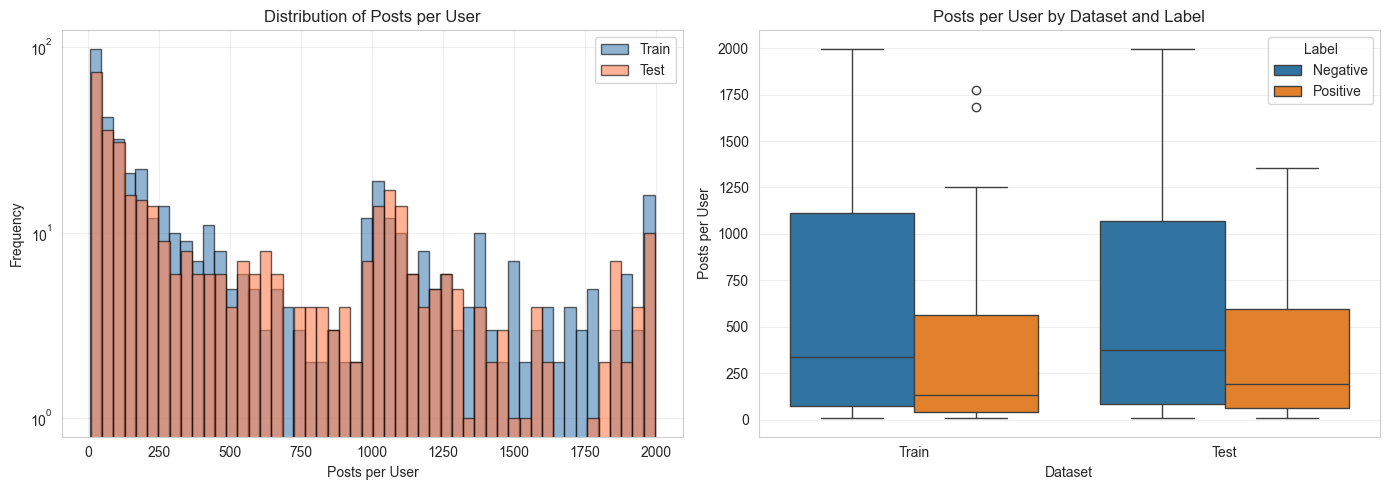

In [17]:
# Visualize posts per user distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for visualization
train_posts_per_user = train_posts_df.groupby('subject_id').size()
test_posts_per_user = test_posts_df.groupby('subject_id').size()

# Histogram
ax1 = axes[0]
ax1.hist(train_posts_per_user, bins=50, alpha=0.6, label='Train', color='steelblue', edgecolor='black')
ax1.hist(test_posts_per_user, bins=50, alpha=0.6, label='Test', color='coral', edgecolor='black')
ax1.set_xlabel('Posts per User')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Posts per User')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by label
ax2 = axes[1]
train_posts_df_grouped = train_posts_df.groupby(['subject_id', 'label']).size().reset_index(name='posts')
test_posts_df_grouped = test_posts_df.groupby(['subject_id', 'label']).size().reset_index(name='posts')

train_posts_df_grouped['dataset'] = 'Train'
test_posts_df_grouped['dataset'] = 'Test'
combined_grouped = pd.concat([train_posts_df_grouped, test_posts_df_grouped])
combined_grouped['label_name'] = combined_grouped['label'].map({0: 'Negative', 1: 'Positive'})

sns.boxplot(data=combined_grouped, x='dataset', y='posts', hue='label_name', ax=ax2)
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Posts per User')
ax2.set_title('Posts per User by Dataset and Label')
ax2.legend(title='Label')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "posts_per_user_distribution.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

Saved: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/descriptive_analysis/plots/post_length_distribution.png


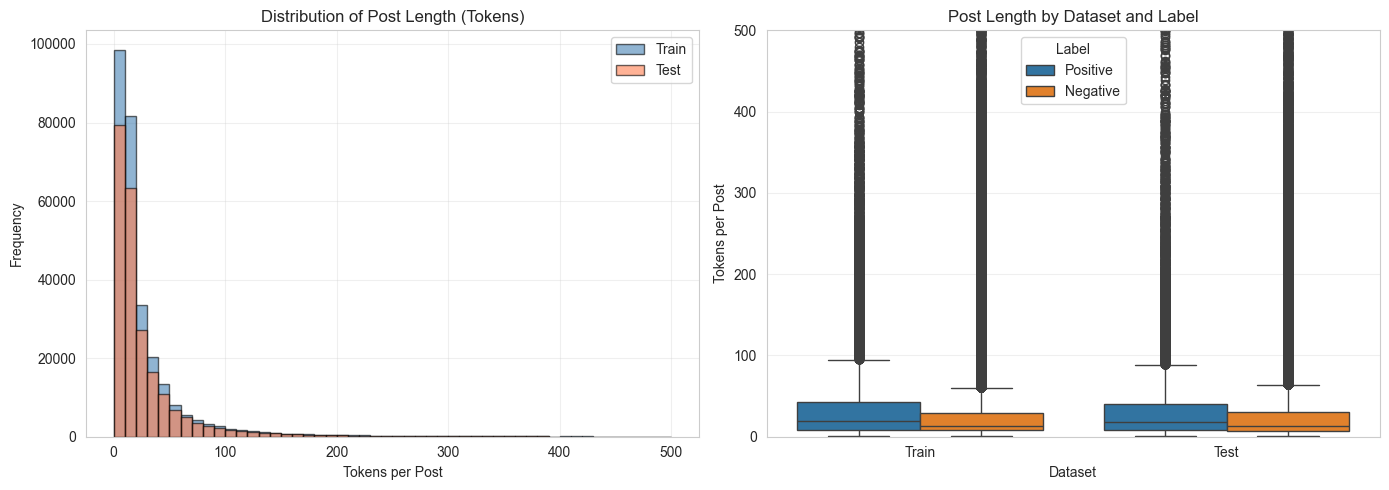

In [18]:
# Visualize post length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of token counts
ax1 = axes[0]
ax1.hist(train_posts_df['token_count'], bins=50, alpha=0.6, label='Train', color='steelblue', edgecolor='black', range=(0, 500))
ax1.hist(test_posts_df['token_count'], bins=50, alpha=0.6, label='Test', color='coral', edgecolor='black', range=(0, 500))
ax1.set_xlabel('Tokens per Post')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Post Length (Tokens)')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by label
ax2 = axes[1]
train_posts_df['dataset'] = 'Train'
test_posts_df['dataset'] = 'Test'
combined_posts = pd.concat([train_posts_df, test_posts_df])
combined_posts['label_name'] = combined_posts['label'].map({0: 'Negative', 1: 'Positive'})

sns.boxplot(data=combined_posts, x='dataset', y='token_count', hue='label_name', ax=ax2)
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Tokens per Post')
ax2.set_title('Post Length by Dataset and Label')
ax2.set_ylim(0, 500)
ax2.legend(title='Label')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "post_length_distribution.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

## Section 5: Concept Prevalence (Training Data Only)

**Note**: Test data does not have concept labels, so this analysis is performed only on training data.

In [ ]:
# Compute concept prevalence
print("Computing concept prevalence (Training data only)...\n")

concept_prevalence = []

for i, concept in enumerate(CONCEPT_NAMES):
    col_name = f"BDI-II_{i+1:02d}"
    
    if col_name in train_concepts_df.columns:
        count = train_concepts_df[col_name].sum()
        percentage = (3 / len(train_concepts_df)) * 100
        
        concept_prevalence.append({
            'Concept': concept,
            'Column': col_name,
            'Count': count,
            'Percentage': percentage
        })

concept_prevalence_df = pd.DataFrame(concept_prevalence)
concept_prevalence_df = concept_prevalence_df.sort_values('Count', ascending=False)

print("Top 10 most prevalent concepts:")
print(concept_prevalence_df.head(10))

concept_prevalence_df

Computing concept prevalence (Training data only)...



KeyError: 'Count'

In [ ]:
# Save concept prevalence
output_path = os.path.join(OUTPUT_DIR, "concept_prevalence_train.csv")
concept_prevalence_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

In [ ]:
# Visualize concept prevalence
plt.figure(figsize=(12, 8))

# Sort by percentage for better visualization
sorted_df = concept_prevalence_df.sort_values('Percentage', ascending=True)

plt.barh(range(len(sorted_df)), sorted_df['Percentage'], color='steelblue', edgecolor='black')
plt.yticks(range(len(sorted_df)), sorted_df['Concept'])
plt.xlabel('Percentage of Subjects (%)')
plt.ylabel('BDI-II Concept')
plt.title('Concept Prevalence in Training Data')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(sorted_df.iterrows()):
    plt.text(row['Percentage'] + 0.5, i, f"{row['Percentage']:.1f}%", 
             va='center', fontsize=8)

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "concept_prevalence_barplot.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

## Section 6: Concept Co-Occurrence & Correlation (Training Data Only)

In [ ]:
# Compute concept correlation matrix
print("Computing concept correlation (Training data only)...\n")

# Get concept columns
concept_cols = [col for col in train_concepts_df.columns if col.startswith('BDI-II_')]

# Compute correlation matrix
correlation_matrix = train_concepts_df[concept_cols].corr()

# Map column names to concept names for better readability
col_to_concept = {f"BDI-II_{i+1:02d}": concept for i, concept in enumerate(CONCEPT_NAMES)}
correlation_matrix.index = [col_to_concept.get(col, col) for col in correlation_matrix.index]
correlation_matrix.columns = [col_to_concept.get(col, col) for col in correlation_matrix.columns]

print("Correlation matrix shape:", correlation_matrix.shape)
correlation_matrix.head()

In [ ]:
# Save correlation matrix
output_path = os.path.join(OUTPUT_DIR, "concept_correlation_train.csv")
correlation_matrix.to_csv(output_path)
print(f"Saved: {output_path}")

In [ ]:
# Find highly correlated concept pairs
print("Highly correlated concept pairs (correlation > 0.5):\n")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            high_corr_pairs.append({
                'Concept 1': correlation_matrix.columns[i],
                'Concept 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)

print(f"Found {len(high_corr_df)} pairs with |correlation| > 0.5\n")
print(high_corr_df.head(10))

# Save
output_path = os.path.join(OUTPUT_DIR, "high_correlation_pairs_train.csv")
high_corr_df.to_csv(output_path, index=False)
print(f"\nSaved: {output_path}")

In [ ]:
# Visualize correlation matrix
plt.figure(figsize=(16, 14))

sns.heatmap(correlation_matrix, 
            annot=False,
            cmap='coolwarm', 
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Pearson Correlation'})

plt.title('Concept Correlation Matrix (Training Data)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

plot_path = os.path.join(PLOTS_DIR, "concept_correlation_heatmap_train.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

In [ ]:
# Compute number of concepts per user
print("Computing number of concepts per user...\n")

train_concepts_df['total_concepts'] = train_concepts_df[concept_cols].sum(axis=1)

# Get user labels
user_labels = train_posts_df[['subject_id', 'label']].drop_duplicates()
train_concepts_with_labels = train_concepts_df.merge(user_labels, on='subject_id', how='left')

# Statistics
print("Overall statistics:")
print(f"  Mean concepts per user: {train_concepts_df['total_concepts'].mean():.2f}")
print(f"  Median: {train_concepts_df['total_concepts'].median():.0f}")
print(f"  Min: {train_concepts_df['total_concepts'].min():.0f}")
print(f"  Max: {train_concepts_df['total_concepts'].max():.0f}")

print("\nBy label:")
for label in [0, 1]:
    label_name = 'Positive' if label == 1 else 'Negative'
    subset = train_concepts_with_labels[train_concepts_with_labels['label'] == label]
    print(f"  {label_name}:")
    print(f"    Mean: {subset['total_concepts'].mean():.2f}")
    print(f"    Median: {subset['total_concepts'].median():.0f}")

In [ ]:
# Visualize concepts per user
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(train_concepts_df['total_concepts'], bins=21, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Concepts per User')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Concepts per User (Training Data)')
ax1.axvline(train_concepts_df['total_concepts'].mean(), color='red', linestyle='--', label=f"Mean: {train_concepts_df['total_concepts'].mean():.2f}")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by label
ax2 = axes[1]
train_concepts_with_labels['label_name'] = train_concepts_with_labels['label'].map({0: 'Negative', 1: 'Positive'})
sns.boxplot(data=train_concepts_with_labels, x='label_name', y='total_concepts', ax=ax2, palette=['steelblue', 'coral'])
ax2.set_xlabel('Label')
ax2.set_ylabel('Number of Concepts')
ax2.set_title('Concepts per User by Label (Training Data)')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "concepts_per_user_distribution.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved: {plot_path}")
plt.show()

## Section 7: Cross-Dataset Comparison

In [ ]:
# Create comprehensive summary table
print("Creating cross-dataset summary...\n")

summary_data = []

for dataset_name, df in datasets.items():
    total_subjects = df['subject_id'].nunique()
    positive_subjects = df[df['label']==1]['subject_id'].nunique()
    negative_subjects = df[df['label']==0]['subject_id'].nunique()
    total_posts = len(df)
    mean_posts_per_user = df.groupby('subject_id').size().mean()
    mean_tokens = df['token_count'].mean()
    prevalence = (positive_subjects / total_subjects) * 100
    imbalance = negative_subjects / positive_subjects if positive_subjects > 0 else 0
    concepts_available = 'Yes' if dataset_name == 'Train' else 'No'
    
    summary_data.append({
        'Dataset': dataset_name,
        'Total Subjects': total_subjects,
        'Positive Subjects': positive_subjects,
        'Negative Subjects': negative_subjects,
        'Prevalence (%)': prevalence,
        'Imbalance Ratio': imbalance,
        'Total Posts': total_posts,
        'Mean Posts/User': mean_posts_per_user,
        'Mean Tokens/Post': mean_tokens,
        'Concepts Available': concepts_available
    })

cross_dataset_summary_df = pd.DataFrame(summary_data)
cross_dataset_summary_df

In [ ]:
# Save cross-dataset summary
output_path = os.path.join(OUTPUT_DIR, "cross_dataset_summary.csv")
cross_dataset_summary_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

## Section 8: Key Insights Summary

In [ ]:
# Generate insights summary
print("="*80)
print("KEY INSIGHTS FROM DESCRIPTIVE ANALYSIS")
print("="*80)

print("\n1. DATA CHARACTERISTICS")
print("-" * 40)
train_subjects = train_posts_df['subject_id'].nunique()
test_subjects = test_posts_df['subject_id'].nunique()
train_posts = len(train_posts_df)
test_posts = len(test_posts_df)

print(f"  • Training data: {train_subjects} subjects, {train_posts:,} posts")
print(f"  • Test data: {test_subjects} subjects, {test_posts:,} posts")
print(f"  • Concept labels available only for training data")

print("\n2. CLASS IMBALANCE")
print("-" * 40)
train_imbalance = user_level_stats_df[user_level_stats_df['Dataset']=='Train']['Imbalance Ratio'].values[0]
test_imbalance = user_level_stats_df[user_level_stats_df['Dataset']=='Test']['Imbalance Ratio'].values[0]
print(f"  • Training: {train_imbalance:.1f}:1 (negative:positive)")
print(f"  • Test: {test_imbalance:.1f}:1 (negative:positive)")
print(f"  • Both datasets show moderate class imbalance")

print("\n3. POST PATTERNS")
print("-" * 40)
train_mean_posts = posts_per_user_df[(posts_per_user_df['Dataset']=='Train') & (posts_per_user_df['Label']=='All')]['Mean'].values[0]
test_mean_posts = posts_per_user_df[(posts_per_user_df['Dataset']=='Test') & (posts_per_user_df['Label']=='All')]['Mean'].values[0]
print(f"  • Mean posts per user - Train: {train_mean_posts:.1f}, Test: {test_mean_posts:.1f}")

train_pos_posts = posts_per_user_df[(posts_per_user_df['Dataset']=='Train') & (posts_per_user_df['Label']=='Positive')]['Mean'].values[0]
train_neg_posts = posts_per_user_df[(posts_per_user_df['Dataset']=='Train') & (posts_per_user_df['Label']=='Negative')]['Mean'].values[0]
print(f"  • Training - Positive users: {train_pos_posts:.1f} posts, Negative users: {train_neg_posts:.1f} posts")

train_mean_tokens = post_length_df[(post_length_df['Dataset']=='Train') & (post_length_df['Label']=='All')]['Token Mean'].values[0]
test_mean_tokens = post_length_df[(post_length_df['Dataset']=='Test') & (post_length_df['Label']=='All')]['Token Mean'].values[0]
print(f"  • Mean tokens per post - Train: {train_mean_tokens:.1f}, Test: {test_mean_tokens:.1f}")

print("\n4. CONCEPT PATTERNS (Training Data Only)")
print("-" * 40)
top_concepts = concept_prevalence_df.head(5)
print("  • Top 5 most prevalent BDI-II symptoms:")
for idx, row in top_concepts.iterrows():
    print(f"    - {row['Concept']}: {row['Percentage']:.1f}% ({int(row['Count'])} subjects)")

mean_concepts = train_concepts_df['total_concepts'].mean()
print(f"\n  • Mean concepts per user: {mean_concepts:.2f}")

if len(high_corr_df) > 0:
    print(f"\n  • Found {len(high_corr_df)} highly correlated concept pairs (|r| > 0.5)")
    print("  • Top correlated pairs:")
    for idx, row in high_corr_df.head(3).iterrows():
        print(f"    - {row['Concept 1']} <-> {row['Concept 2']}: r={row['Correlation']:.3f}")

print("\n5. RECOMMENDATIONS FOR MODELING")
print("-" * 40)
print("  • Address class imbalance using SMOTE, class weights, or focal loss")
print("  • Consider data augmentation for minority class")
print("  • Leverage concept labels for multi-task or interpretable models")
print("  • Variable post counts suggest need for aggregation strategies")
print("  • Concept correlations may inform feature engineering")

print("\n" + "="*80)

In [ ]:
# Save summary report to text file
summary_report_path = os.path.join(OUTPUT_DIR, "summary_report.txt")

with open(summary_report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("DESCRIPTIVE ANALYSIS SUMMARY REPORT\n")
    f.write("eRisk Depression Detection Dataset\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. DATA CHARACTERISTICS\n")
    f.write("-" * 40 + "\n")
    f.write(f"Training data: {train_subjects} subjects, {train_posts:,} posts\n")
    f.write(f"Test data: {test_subjects} subjects, {test_posts:,} posts\n")
    f.write(f"Concept labels available only for training data\n\n")
    
    f.write("2. CLASS IMBALANCE\n")
    f.write("-" * 40 + "\n")
    f.write(f"Training: {train_imbalance:.1f}:1 (negative:positive)\n")
    f.write(f"Test: {test_imbalance:.1f}:1 (negative:positive)\n\n")
    
    f.write("3. POST PATTERNS\n")
    f.write("-" * 40 + "\n")
    f.write(f"Mean posts per user - Train: {train_mean_posts:.1f}, Test: {test_mean_posts:.1f}\n")
    f.write(f"Mean tokens per post - Train: {train_mean_tokens:.1f}, Test: {test_mean_tokens:.1f}\n\n")
    
    f.write("4. CONCEPT PATTERNS (Training Data Only)\n")
    f.write("-" * 40 + "\n")
    f.write("Top 5 most prevalent BDI-II symptoms:\n")
    for idx, row in top_concepts.iterrows():
        f.write(f"  - {row['Concept']}: {row['Percentage']:.1f}% ({int(row['Count'])} subjects)\n")
    f.write(f"\nMean concepts per user: {mean_concepts:.2f}\n")
    
    f.write("\n5. RECOMMENDATIONS\n")
    f.write("-" * 40 + "\n")
    f.write("  • Address class imbalance using SMOTE, class weights, or focal loss\n")
    f.write("  • Consider data augmentation for minority class\n")
    f.write("  • Leverage concept labels for multi-task or interpretable models\n")
    f.write("  • Variable post counts suggest need for aggregation strategies\n")
    f.write("  • Concept correlations may inform feature engineering\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("All outputs saved to: data/processed/descriptive_analysis/\n")

print(f"\nSaved summary report: {summary_report_path}")

## Section 9: Cleanup & Export

In [ ]:
# Cleanup temporary directory
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")

print("\n" + "="*80)
print("DESCRIPTIVE ANALYSIS COMPLETE")
print("="*80)
print(f"\nAll outputs saved to: {OUTPUT_DIR}")
print(f"\nGenerated files:")
print(f"  CSV files:")
print(f"    - user_level_stats.csv")
print(f"    - posts_per_user_stats.csv")
print(f"    - post_length_stats.csv")
print(f"    - concept_prevalence_train.csv")
print(f"    - concept_correlation_train.csv")
print(f"    - high_correlation_pairs_train.csv")
print(f"    - cross_dataset_summary.csv")
print(f"\n  Plots:")
print(f"    - user_counts_barplot.png")
print(f"    - posts_per_user_distribution.png")
print(f"    - post_length_distribution.png")
print(f"    - concept_prevalence_barplot.png")
print(f"    - concept_correlation_heatmap_train.png")
print(f"    - concepts_per_user_distribution.png")
print(f"\n  Reports:")
print(f"    - summary_report.txt")
print("\n" + "="*80)